In [15]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
import copy
import matplotlib.pyplot as plt
import math
import os
from omegaconf import OmegaConf

import torch
from torch_geometric.utils import to_dense_adj
import torchvision.transforms as T
from fsspec.core import url_to_fs
from hydra.utils import instantiate
from trainer.data.util import AddCanvasElement, AddRelationConstraints, sparse_to_dense
from trainer.global_configs import DATASET_DIR, JOB_DIR
from trainer.helpers.layout_tokenizer import LayoutSequenceTokenizer
from trainer.helpers.sampling import SAMPLING_CONFIG_DICT
from trainer.helpers.task import get_cond, filter_canvas
from trainer.helpers.visualization import save_gif, save_image, save_label, save_label_with_size, save_relation
from trainer.hydra_configs import TestConfig

SIZE = (360, 240)

# user tunable parameters
# cond_type, W_CANVAS = "relation", True  # uncomment this line if you want to try relation task
cond_type, W_CANVAS = "cwh", False  # choices: unconditional, c, cwh, partial, refinement
n_samples = 4  # num. of samples to generate at once
target_index = 0  # index of real data, partial fields in it are used for conditional generation

job_dir = os.path.join(JOB_DIR, "layoutdm_publaynet/0")

config_path = os.path.join(job_dir, "config.yaml")
fs, _ = url_to_fs(config_path)
if fs.exists(config_path):
    with fs.open(config_path, "rb") as file_obj:
        train_cfg = OmegaConf.load(file_obj)
else:
    raise FileNotFoundError
train_cfg.dataset.dir = DATASET_DIR

test_cfg = OmegaConf.structured(TestConfig)
test_cfg.cond = cond_type
device = "cuda" if torch.cuda.is_available() else "cpu"

sampling_cfg = OmegaConf.structured(SAMPLING_CONFIG_DICT[test_cfg.sampling])  # NOTE: you may change sampling algorithm
OmegaConf.set_struct(sampling_cfg, False)

In [17]:
# initialize data and model
tokenizer = LayoutSequenceTokenizer(
    data_cfg=train_cfg.data, dataset_cfg=train_cfg.dataset
)
model = instantiate(train_cfg.model)(
    backbone_cfg=train_cfg.backbone, tokenizer=tokenizer
).to(device)
model_path = os.path.join(job_dir, "best_model.pt")
with fs.open(model_path, "rb") as file_obj:
    model.load_state_dict(torch.load(file_obj))
model = model.to(device)
model.eval()
sampling_cfg = model.aggregate_sampling_settings(sampling_cfg, test_cfg)

if W_CANVAS:
    # add canvas and shift label id to load relation gts
    assert cond_type == "relation"
    transform = T.Compose([
        AddCanvasElement(),
        AddRelationConstraints(edge_ratio=0.1),
    ])
else:
    assert cond_type != "relation"
    transform = None
dataset = instantiate(train_cfg.dataset)(split="test", transform=transform)
save_kwargs = {
    "colors": dataset.colors, "names": dataset.labels,
    "canvas_size": SIZE, "use_grid": True,
    # "draw_label": True,
}


### Real data visualization

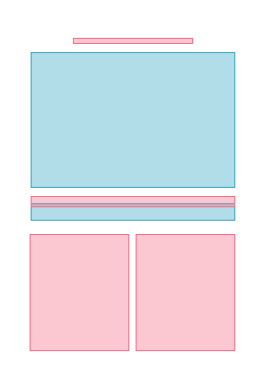

In [18]:
# load target data and visualize GT
bbox, label, _, mask = sparse_to_dense(dataset[target_index])
gt_cond = model.tokenizer.encode(
    {"label": label, "mask": mask, "bbox": bbox}
)
if "bos" in tokenizer.special_tokens:
    gt = model.tokenizer.decode(gt_cond["seq"][:, 1:])
else:
    gt = model.tokenizer.decode(gt_cond["seq"])
if W_CANVAS:
    gt = filter_canvas(gt)  # remove canvas attributes before visualization
plt.axis("off")
plt.imshow(save_image(gt["bbox"], gt["label"], gt["mask"], **save_kwargs))


### Unconditional Generation

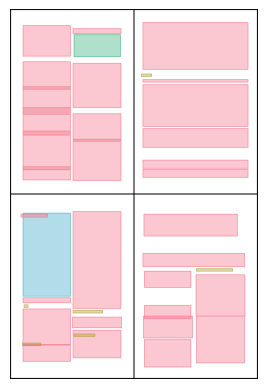

In [19]:
'''
最初の行、assert文をコメントアウトしました。
どのようなエラーが来ているのか分析するのが面倒だったので無視して動かしました。
確認しておいてね。

千葉
'''
#assert cond_type == "unconditional"
pred = model.sample(batch_size=n_samples, cond=None, sampling_cfg=sampling_cfg)
plt.axis("off")
plt.imshow(save_image(pred["bbox"], pred["label"], pred["mask"], **save_kwargs))

### Conditional Generation

#### Prediction

In [20]:
cond = get_cond(
    batch=dataset[target_index],
    tokenizer=model.tokenizer,
    cond_type=cond_type,
    model_type=type(model).__name__,
)
pred = model.sample(batch_size=n_samples, cond=cond, sampling_cfg=sampling_cfg)

#### Visualization of conditional inputs

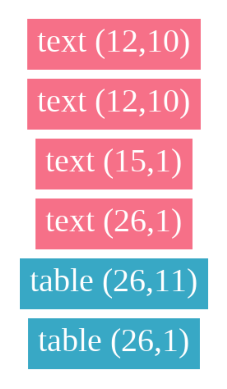

In [21]:
plt.axis("off")
input_ = model.tokenizer.decode(cond["seq"].cpu())
mask = pred["mask"][0]
label, bbox = pred["label"][0][mask], pred["bbox"][0][mask]
if cond_type == "c":
    plt.imshow(save_label(label, **save_kwargs))
elif cond_type == "cwh":
    plt.imshow(save_label_with_size(label, bbox, **save_kwargs))
elif cond_type == "relation":
    data = cond["batch_w_canvas"]
    edge_attr = to_dense_adj(data.edge_index, data.batch, data.edge_attr)
    plt.imshow(save_relation(label_with_canvas=data.y.cpu(), edge_attr=edge_attr.cpu()[0], **save_kwargs))
elif cond_type  == "partial":
    plt.imshow(save_image(input_["bbox"], input_["label"], input_["mask"], **save_kwargs))
elif cond_type == "refinement":
    noisy_input = model.tokenizer.decode(cond["seq_orig"].cpu())
    plt.imshow(save_image(noisy_input["bbox"][0:1], noisy_input["label"][0:1], noisy_input["mask"][0:1], **save_kwargs))


#### Visualization of outputs

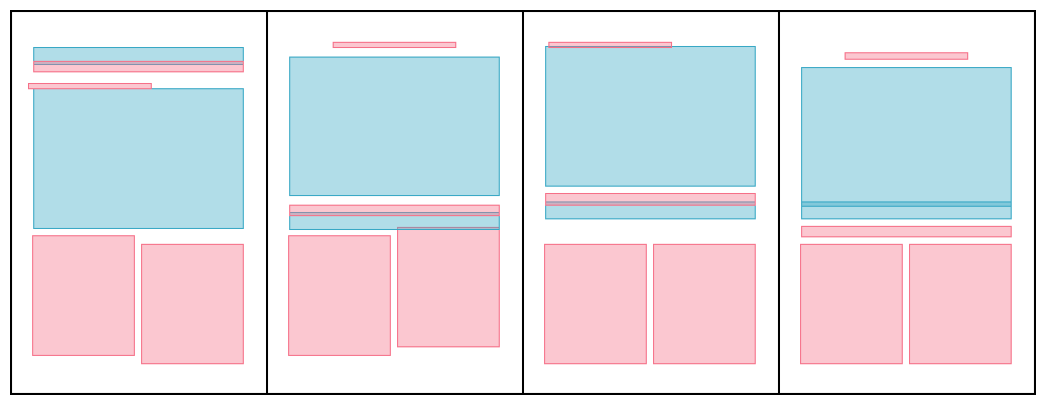

In [22]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.set_axis_off()
ax.imshow(save_image(pred["bbox"], pred["label"], pred["mask"], **save_kwargs, nrow=int(math.sqrt(n_samples) * 2)))

#### Make GIF for Unconditional Generation

In [23]:
'''
ここもGIFファイルを作成するのにエラーが起こっていたので丸々コメントアウトします。
直したかったら直しておいてね。

千葉
'''

'''
new_save_kwargs = copy.deepcopy(save_kwargs)
new_save_kwargs.pop("use_grid")
ids_list = model.model.sample(
    batch_size=4,
    sampling_cfg=sampling_cfg,
    get_intermediate_results=True,
)
images = []
for ids in ids_list:
    layouts = model.tokenizer.decode(ids)
    image = save_image(
        layouts["bbox"],
        layouts["label"],
        layouts["mask"],
        **new_save_kwargs
    )
    images.append(image)
N_step = len(images)
images = images[int(0.5*N_step):]
save_gif(images, "../tmp/animation/{}.gif")
'''


'\nnew_save_kwargs = copy.deepcopy(save_kwargs)\nnew_save_kwargs.pop("use_grid")\nids_list = model.model.sample(\n    batch_size=4,\n    sampling_cfg=sampling_cfg,\n    get_intermediate_results=True,\n)\nimages = []\nfor ids in ids_list:\n    layouts = model.tokenizer.decode(ids)\n    image = save_image(\n        layouts["bbox"],\n        layouts["label"],\n        layouts["mask"],\n        **new_save_kwargs\n    )\n    images.append(image)\nN_step = len(images)\nimages = images[int(0.5*N_step):]\nsave_gif(images, "../tmp/animation/{}.gif")\n'

#### Dump colors of all labels

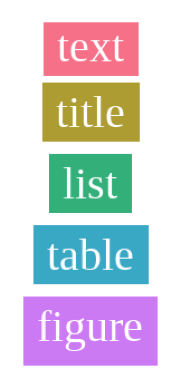

In [24]:
labels = []
for i, name in enumerate(save_kwargs["names"]):
    if "_cutout" in name:
        continue
    else:
        labels.append(i)
plt.axis("off")
plt.imshow(save_label(labels, **save_kwargs))